importent import

In [252]:
import numpy as np , os
import tensorflow as tf
import collections

gpus = tf.config.list_physical_devices('GPU')
tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data Preparation
## Quelle  https://medium.com/hackernoon/implementing-a-sequence-to-sequence-model-45a6133958ca

In [253]:
questions = []
answers = []

In [254]:
import os

folder_path = 'data_generation/newQuestions'  # Geben Sie den Pfad zum gewünschten Ordner an

# Durchlaufen aller Dateien im Ordner
que = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
folder_path = 'data_generation/newAnswers' 
ans = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
print(len(que))
print(len(ans))

33
33


In [255]:
for (q,a) in zip(que,ans):
    with open(q, 'r') as inputfile:
        questions += [line.rstrip() for line in inputfile.readlines()[1:]]
    with open(a, 'r') as inputfile:
        answers += [line.rstrip() for line in inputfile.readlines()[1:]]     


In [256]:
print(len(questions))

791


In [257]:
print(len(answers))

791


Einlesen der Fragen

In [258]:
#my better version
file_path = './processed_data/'

with open(file_path+'all_fragen.txt', 'r') as inputfile:
    questions += [line.rstrip() for line in inputfile.readlines()]
    

with open(file_path+'all_antworten.txt', 'r') as inputfile:
    answers += [line.rstrip() for line in inputfile.readlines()]

print(' count questions: %d, count answers: %d'%(len(questions), len(answers)))
#print(antworten)

 count questions: 1099, count answers: 1099


In [259]:
import random
sample_questions = []
sample_answers = []
for x in range(10):
    number = random.randint(0, len(questions))
    #print(str(number))
    sample_questions += [questions[number]]
    sample_answers += [answers[number]]


#for (x,y) in zip(sample_questions,sample_answers):
    #print(x + "\n" + y + "\n \n")

make them all lowercase because that should be better simpler for the net

In [260]:
import re
def make_clean(sentences):
    result = []
    for sentence in sentences:
        txt = sentence.lower()
        txt = re.sub(r"i'm", "i am", txt)
        txt = re.sub(r"he's", "he is", txt)
        txt = re.sub(r"she's", "she is", txt)
        txt = re.sub(r"that's", "that is", txt)
        txt = re.sub(r"what's", "what is", txt)
        txt = re.sub(r"where's", "where is", txt)
        txt = re.sub(r"\'ll", " will", txt)
        txt = re.sub(r"\'ve", " have", txt)
        txt = re.sub(r"\'re", " are", txt)
        txt = re.sub(r"\'d", " would", txt)
        txt = re.sub(r"won't", "will not", txt)
        txt = re.sub(r"can't", "can not", txt)
        txt = re.sub(r"[^\w\s]", "", txt)
        result += [txt]
    return result
bla = ['WHOI o ! ','PAxx s s\' ']
bla = make_clean(bla)
print(bla)

['whoi o  ', 'paxx s s ']


In [261]:
clean_ques = make_clean(questions)
clean_ans = make_clean(answers)

In [262]:
###  count occurences ###
counter_words = {}

for line in clean_ques:
    for word in line.split():
        if word not in counter_words:
            counter_words[word] = 1
        else:
            counter_words[word] += 1
for line in clean_ans:
    for word in line.split():
        if word not in counter_words:
            counter_words[word] = 1
        else:
            counter_words[word] += 1


In [263]:
vocab = {}
word_num = 0
for word, count in counter_words.items():
    vocab[word] = word_num
    word_num += 1

In [264]:
print(vocab)
print(len(vocab))

{'how': 0, 'does': 1, 'tacotron': 2, '2': 3, 'utilize': 4, 'a': 5, 'sequencetosequence': 6, 'architecture': 7, 'what': 8, 'is': 9, 'the': 10, 'purpose': 11, 'of': 12, 'spectral': 13, 'encoder': 14, 'in': 15, 'generate': 16, 'speech': 17, 'from': 18, 'spectrograms': 19, 'role': 20, 'wavenet': 21, 'vocoder': 22, 'are': 23, 'character': 24, 'embeddings': 25, 'used': 26, 'advantages': 27, 'using': 28, 'convolutional': 29, 'networks': 30, 'lstm': 31, 'long': 32, 'shortterm': 33, 'memory': 34, 'relationship': 35, 'between': 36, 'and': 37, 'synthesis': 38, 'handle': 39, 'sentences': 40, 'improvements': 41, 'bring': 42, 'compared': 43, 'to': 44, 'its': 45, 'previous': 46, 'version': 47, 'variations': 48, 'pitch': 49, 'intonation': 50, 'challenges': 51, 'face': 52, 'handling': 53, 'different': 54, 'languages': 55, 'multiple': 56, 'speakers': 57, 'techniques': 58, 'employ': 59, 'ensure': 60, 'naturalsounding': 61, 'with': 62, 'background': 63, 'noise': 64, 'limitations': 65, 'terms': 66, 'genera

start and stop simbole hinzufügen

In [265]:
for i in range(len(clean_ans)):
    clean_ans[i] = '<SOS> ' + clean_ans[i] + ' <EOS>'

anpassen des dics

In [266]:
tokens = ['<PAD>', '<EOS>', '<OUT>', '<SOS>']
x = len(vocab)
print(x)
for token in tokens:
    vocab[token] = x
    x += 1
    
    
vocab['cameron'] = vocab['<PAD>']
vocab['<PAD>'] = 0
print(len(vocab))


1129
1134


In [267]:
### inv answers dict ###
inv_vocab = {w:v for v, w in vocab.items()}

In [268]:
print(len(inv_vocab))

1133


Incoder input durch questions 
wenn Wort nicht bekannt dann vocab out

In [269]:
encoder_inp = []
for line in clean_ques:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])
        
    encoder_inp.append(lst)

decoder_inp = []
for line in clean_ans:
    lst = []
    for word in line.split():
        if word not in vocab:
            lst.append(vocab['<OUT>'])
        else:
            lst.append(vocab[word])        
    decoder_inp.append(lst)

### delete
del(clean_ans, clean_ques, line, lst, word)    

# found longest length

In [270]:
longest_sequence = 0
for x in encoder_inp+decoder_inp:
    
    if len(x) > longest_sequence:
        longest_sequence = len(x)     
print(longest_sequence)         

26


padding

In [271]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_inp = pad_sequences(encoder_inp, longest_sequence, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, longest_sequence, padding='post', truncating='post')

In [272]:
#print(encoder_inp)
#print(decoder_inp)
def make_vector_to_sequence(input, dic):
    ints = []
    for k in input:
        try:
            ints.append(inv_vocab[k])
        except Exception as e:
            ints.append(inv_vocab[2])
        
    return ints    

x = make_vector_to_sequence(decoder_inp[5],vocab)
print(x)
x = make_vector_to_sequence(encoder_inp[5],vocab)
print(x)

['<SOS>', 'convolutional', 'networks', 'help', 'capture', 'local', 'dependencies', 'in', 'tacotron', '2', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['what', 'are', 'the', 'advantages', 'of', 'using', 'convolutional', 'networks', 'in', 'tacotron', '2', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


remove the "start of the sequence" simbol in the beginning

In [273]:
decoder_final_output = []
for i in decoder_inp:
    decoder_final_output.append(i[1:]) 

decoder_final_output = pad_sequences(decoder_final_output, longest_sequence, padding='post', truncating='post')

In [274]:
num_categories = len(vocab)  # Check the actual size of your vocabular

In [275]:
#decoder_final_output

convert 2d data to 3d for the LSTM units
creates a separate column for every word in the vocabulary

In [276]:
from tensorflow.keras.utils import to_categorical

num_categories = len(vocab)  # Check the actual size of your vocabulary

# Debugging statements
print("Number of categories:", num_categories)
print("Decoder final output shape:", decoder_final_output.shape)
print("Maximum value in decoder final output:", decoder_final_output.max())

# Convert to one-hot encoded representation
decoder_final_output = to_categorical(decoder_final_output, num_categories)

print(decoder_final_output.shape)

Number of categories: 1134
Decoder final output shape: (1099, 26)
Maximum value in decoder final output: 1130
(1099, 26, 1134)


In [277]:
#print(decoder_final_output)

Verwenden von keras instatt of sequencial weil mehr kontrolle

In [278]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# for both

enc_inp = Input(shape=(longest_sequence, ))
dec_inp = Input(shape=(longest_sequence, ))
# embedding layer reduces dimensionality
# Compress output dim -> voc 722  bzw 300 
VOCAB_SIZE = len(vocab)

# normal Modell

In [279]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input,Dropout

def normalModel():
    # embedding layer reduces dimensionality
    # Compress output dim -> voc 722  bzw 300 
    embed = Embedding(VOCAB_SIZE+1, output_dim=300, 
                    input_length=longest_sequence,
                    trainable=True                  
                    )
    enc_embed = embed(enc_inp)
    # erstelen LSTM mit dimensionilität von 400 
    # sequence von eingabeVektoren in Ausgabe Vektoren
    # h (hidden state): Der letzte verborgene Zustand des LSTM-Layers. 
    # Der verborgene Zustand enthält Kontext der Eingabesequenz bis zur letzten Zeitstufe.
    # c (cell state): Der letzte Zellzustand des LSTM-Layers. 
    # Der Zellzustand speichert Informationen über  langfristige Abhängigkeiten in Eingabesequenz.
    enc_lstm = LSTM(800, return_sequences=True, return_state=True)
    enc_op, h, c = enc_lstm(enc_embed)
    enc_states = [h, c]


    # Decoder LSTM
    dec_embed = embed(dec_inp)
    dec_lstm = LSTM(800, return_sequences=True, return_state=True)
    dec_op, _, _ = dec_lstm(dec_embed, initial_state=enc_states)

    # output is propability of how propable the words are
    dense = Dense(VOCAB_SIZE, activation='softmax')
    # dense verknüpfen mit decoder output
    dense_op = dense(dec_op)
    return Model([enc_inp, dec_inp], dense_op),dec_embed,enc_states,dec_lstm,dense

In [280]:
#model,dec_embed,enc_states = normalModel()

In [281]:
def otherModel():
    enc_inp = Input(shape=(longest_sequence, ))
    dec_inp = Input(shape=(longest_sequence, ))

    VOCAB_SIZE = len(vocab)
    embed = Embedding(VOCAB_SIZE+1, output_dim=300, input_length=longest_sequence, trainable=True)
    enc_embed = embed(enc_inp)

    enc_lstm1 = LSTM(800, return_sequences=True, return_state=True)
    enc_op1, h1, c1 = enc_lstm1(enc_embed)
    enc_states1 = [h1, c1]

    enc_lstm2 = LSTM(800, return_sequences=True, return_state=True)
    enc_op2, h2, c2 = enc_lstm2(enc_op1)
    enc_states2 = [h2, c2]

    dec_embed = embed(dec_inp)

    dec_lstm1 = LSTM(800, return_sequences=True, return_state=True)
    dec_op1, _, _ = dec_lstm1(dec_embed, initial_state=enc_states2)

    dec_lstm2 = LSTM(800, return_sequences=True, return_state=True)
    dec_op2, _, _ = dec_lstm2(dec_op1, initial_state=enc_states1)

    dropout = Dropout(0.2)
    dec_op_dropout = dropout(dec_op2)

    dense = Dense(VOCAB_SIZE, activation='softmax')
    dense_op = dense(dec_op_dropout)

    return Model([enc_inp, dec_inp], dense_op),dec_embed,enc_states1,dec_lstm2,dense

In [282]:
train_data_X = encoder_inp[:1000]
train_data_Y = decoder_inp[:1000]
val_data_X = encoder_inp[1000:]
val_data_Y = encoder_inp[1000:]
print(train_data_X[0])
print(val_data_X[0])

[0 1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  0   1   2   3 138  32  33  34  30   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [283]:
from tensorflow.keras.optimizers import Adam
#import pandas as pd

In [284]:
model,dec_embed,enc_states,dec_lstm,dense = otherModel()
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

In [285]:
#model2 = Model([enc_inp, dec_inp], dense_op)
with tf.device('/GPU:0'):
            history = model.fit([train_data_X, train_data_Y], decoder_final_output[:1000],
            validation_data=([val_data_X, val_data_Y], decoder_final_output[1000:]),
            epochs=100, batch_size=200)
#history_frame = pd.DataFrame(history.history())
#history_frame.loc[:, ['loss', 'val_loss']].plot()
#history_frame.loc[:, ['acc', 'categorical_crossentropy']].plot()

Epoch 1/100
5/5 [==============================] - 21s 3s/step - loss: 5.6354 - acc: 0.4154 - val_loss: 4.3222 - val_acc: 0.5144
Epoch 2/100
5/5 [==============================] - 15s 3s/step - loss: 3.3762 - acc: 0.5307 - val_loss: 3.3529 - val_acc: 0.5066
Epoch 3/100
5/5 [==============================] - 15s 3s/step - loss: 2.7068 - acc: 0.5443 - val_loss: 3.3713 - val_acc: 0.5078
Epoch 4/100
5/5 [==============================] - 15s 3s/step - loss: 2.5889 - acc: 0.5394 - val_loss: 3.3849 - val_acc: 0.5272
Epoch 5/100
5/5 [==============================] - 16s 3s/step - loss: 2.5225 - acc: 0.5518 - val_loss: 3.3519 - val_acc: 0.5287
Epoch 6/100
5/5 [==============================] - 16s 3s/step - loss: 2.4771 - acc: 0.5547 - val_loss: 3.3310 - val_acc: 0.5245
Epoch 7/100
5/5 [==============================] - 16s 3s/step - loss: 2.5268 - acc: 0.5471 - val_loss: 3.3353 - val_acc: 0.5218
Epoch 8/100
5/5 [==============================] - 16s 3s/step - loss: 2.4845 - acc: 0.5478 - val

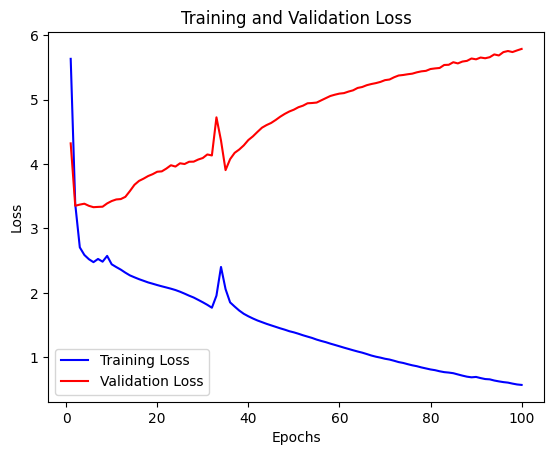

In [295]:
import matplotlib.pyplot as plt

# Get the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

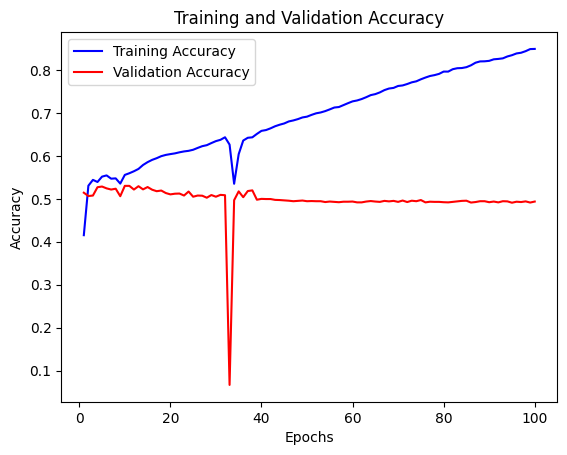

In [287]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

# Plot the training and validation loss
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [288]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU detected.")

No GPU detected.


In [289]:
#model.save('models/normalModel_100Epochs.h5')

In [290]:
#model = otherModel()
#model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')
#history = model.fit([train_data_X, train_data_Y], decoder_final_output[:1000],
#          validation_data=([val_data_X, val_data_Y], decoder_final_output[1000:]),
#          epochs=100, batch_size=150)
#history_frame = pd.DataFrame(history.history())
#history_frame.loc[:, ['loss', 'val_loss']].plot()
#history_frame.loc[:, ['acc', 'categorical_crossentropy']].plot()

In [291]:
#model2 = Model([enc_inp, dec_inp], dense_op)
#from tensorflow.keras.optimizers import Adam
#model2.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')
#history = model2.fit([encoder_inp,decoder_inp], decoder_final_output,epochs=50, batch_size=150)

In [292]:
#!pip install tensorflow-gpu
#print(tf.test.gpu_device_name())
#!pip install pandas
#!pip install matplotlib

In [293]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 26, 300)      340500      ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 26, 800),    3523200     ['embedding_5[0][0]']      

To use modell have to use Interence
To use the modell we need the enc_states

In [294]:
enc_model = Model([enc_inp], enc_states)

# decoder Model
decoder_state_input_h = Input(shape=(800,))
decoder_state_input_c = Input(shape=(800,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# wir verwenden LSTM units mit den trainierten states
# h war hidden state mit Information Kontext 
# c cell state mit Inforamtion über Abhängigkeiten
decoder_outputs, state_h, state_c = dec_lstm(dec_embed , 
                                    initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

dec_model = Model([dec_inp]+ decoder_states_inputs,
                                      [decoder_outputs]+ decoder_states)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 26), dtype=tf.float32, name='input_23'), name='input_23', description="created by layer 'input_23'") at layer "embedding_5". The following previous layers were accessed without issue: []

In [ ]:
def create_pred_input(sentence):
    X_in = []
    for word in sentence.lower().split():
        try:
            X_in.append(vocab[word])
        except:
            X_in.append(vocab['<OUT>'])
            pass
    print(X_in)    
    return pad_sequences([X_in], longest_sequence, padding='post')

input_for_prediction = create_pred_input('What is Tacotron 2 ?')

[8, 9, 2, 3, 1131]


In [ ]:
def predict_sentence(sentences):
    sentences = make_clean(sentences)
    for sentence in sentences:
        print("Question  : " + sentence + "/n")
        pred_input = create_pred_input(sentence)
        stat = enc_model.predict(pred_input)
        print("make predicted Input for " + str(pred_input))
        empty_target_seq = np.zeros( ( 1 , 1) )
        ##   empty_target_seq = [0]
        empty_target_seq[0, 0] = vocab['<SOS>']       

        stop_condition = False
        decoded_translation = ''
        while not stop_condition :

            dec_outputs , h, c= dec_model.predict([ empty_target_seq] + stat )
            decoder_concat_input = dense(dec_outputs)
            ## decoder_concat_input = [0.1, 0.2, .4, .0, ...............]

            sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )
            ## sampled_word_index = [2]

            sampled_word = inv_vocab[sampled_word_index] + ' '

            ## inv_vocab[2] = 'hi'
            ## sampled_word = 'hi '

            if sampled_word != '<EOS> ':
                decoded_translation += sampled_word  

            if sampled_word == '<EOS> ' or len(decoded_translation.split()) > longest_sequence:
                stop_condition = True 

            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            ## <SOS> - > hi
            ## hi --> <EOS>
            stat = [h, c]  

        print("chatbot : ", decoded_translation )
        print("============================================== \n")  

In [ ]:
Testset = ["How does Tacotron 2 utilize a Sequence-to-Sequence architecture?",
"What is the purpose of the Spectral Encoder in Tacotron 2?",
"How does Tacotron 2 generate speech from spectrograms?"
"What is the role of the WaveNet Vocoder in Tacotron 2",
"How are character embeddings used in Tacotron 2?",
"What are the advantages of using convolutional networks in Tacotron 2?"]
#print(])
predict_sentence([questions[0],questions[1],questions[2]])
#predict_sentence(answers[0])

Question  : how does tacotron 2 utilize a sequencetosequence architecture/n
[0, 1, 2, 3, 4, 5, 6, 7]
1/1 [==============================] - 0s 24ms/step
make predicted Input for [[0 1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 17ms/step
chatbot :  tacotron 2 utilizes lstm to model temporal dependencies in speech generation 

Question  : what is the purpose of the spectral encoder in tacotron 2/n
[8, 9, 10, 11, 12, 10, 13, 14, 15, 2, 3]
1/1 [==============================] - 0s 21ms/step
make predicted Input for [[ 8  9 10 11 12 10 13 14 15  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
1/1 [==============================] - 0s 17ms/step
chatbot :  the spectral encoder in tacotron 2 extracts acoustic features from the input text 

Question  : how does tacotron 2 generate speech from spectrograms/n
[0, 1, 2, 3, 16, 17, 18, 19]
1/1 [==============================] - 0s 25ms/step
make predicted Input for [[ 0  1  2  3 16 17 18 19  0 

In [ ]:
print(vocab)

{'how': 0, 'does': 1, 'tacotron': 2, '2': 3, 'utilize': 4, 'a': 5, 'sequencetosequence': 6, 'architecture': 7, 'what': 8, 'is': 9, 'the': 10, 'purpose': 11, 'of': 12, 'spectral': 13, 'encoder': 14, 'in': 15, 'generate': 16, 'speech': 17, 'from': 18, 'spectrograms': 19, 'role': 20, 'wavenet': 21, 'vocoder': 22, 'are': 23, 'character': 24, 'embeddings': 25, 'used': 26, 'advantages': 27, 'using': 28, 'convolutional': 29, 'networks': 30, 'lstm': 31, 'long': 32, 'shortterm': 33, 'memory': 34, 'relationship': 35, 'between': 36, 'and': 37, 'synthesis': 38, 'handle': 39, 'sentences': 40, 'improvements': 41, 'bring': 42, 'compared': 43, 'to': 44, 'its': 45, 'previous': 46, 'version': 47, 'variations': 48, 'pitch': 49, 'intonation': 50, 'challenges': 51, 'face': 52, 'handling': 53, 'different': 54, 'languages': 55, 'multiple': 56, 'speakers': 57, 'techniques': 58, 'employ': 59, 'ensure': 60, 'naturalsounding': 61, 'with': 62, 'background': 63, 'noise': 64, 'limitations': 65, 'terms': 66, 'genera

In [ ]:
Testset = ["Can the Tacotron 2 deal with speech",
           "Can it generate speech",
           "what are current challenges",
           "Is it a sequence2sequ"
           ]
predict_sentence(Testset)

Question  : can the tacotron 2 deal with speech/n
[119, 10, 2, 3, 68, 62, 17]
1/1 [==============================] - 0s 22ms/step


make predicted Input for [[119  10   2   3  68  62  17   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
1/1 [==============================] - 0s 17ms/step
chatbot :  tacotron 2 has advantages over traditional methods in generating natural speech 

Question  : can it generate speech/n
[119, 497, 16, 17]
1/1 [==============================] - 0s 22ms/step
make predicted Input for [[119 497  16  17   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
1/1 [==============================] - 0s 26ms/step
chatbot :  tacotron 2 has the potential to generate speech in multiple languages 

Question  : what are current challenges/n
[8, 23, 215, 51]
1/1 [==============================] - 0s 24ms/step
make predicted Input for [[  8  23 215  51   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
1/1 [==============================] - 0s 18ms/step
chatbot :  training tacotron 2 is computatio

In [ ]:
Testset = ["Is Tacotron an apple ?"]
predict_sentence(Testset)

Question  : is tacotron an apple /n
[9, 2, 626, 1131]
1/1 [==============================] - 0s 24ms/step
make predicted Input for [[   9    2  626 1131    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
1/1 [==============================] - 0s 17ms/step
chatbot :  the training process for tacotron 2 involves teacherforcing and guided attention 



In [ ]:
def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = longest_sequence
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(longest_sequence)
    return padded_seqs, seq_lens

In [ ]:
def predict_sentence(sentence):
    X_in = []
    for word in sentence.split():
        try:
            X_in.append(vocab[word])
        except:
            X_in.append(vocab['<PAD>'])
            pass
    test, seq_x = pad_sentence_batch([X_in], vocab['<PAD>'])
    input_batch = np.zeros([1,seq_x[0]])
    input_batch[0] =test[0]      
    return model.predict(test, seq_x)
    
res = predict_sentence('What is Tacotron 2')    


#   result=' '.join(rev_dictionary_to[i] for i in log[0])
#   return result

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [ ]:
def predict(sentence):
    X_in = []
    for word in sentence.split():
        try:
            X_in.append(dictionary_from[word])
        except:
            X_in.append(PAD)
            pass
        
    test, seq_x = pad_sentence_batch([X_in], PAD)
    input_batch = np.zeros([batch_size,seq_x[0]])
    input_batch[0] =test[0] 
        
    log = sess.run(tf.argmax(model.logits,2), 
                                      feed_dict={
                                              model.X:input_batch,
                                              model.X_seq_len:seq_x,
                                              model.Y_seq_len:seq_x
                                              }
                                      )
    
    result=' '.join(rev_dictionary_to[i] for i in log[0])
    return result

In [ ]:
concat_from = ' '.join(questions).split()
vocabulary_size_from = len(list(set(concat_from)))
data_from, count_from, dictionary_from, rev_dictionary_from = build_dataset(concat_from, vocabulary_size_from)
print('vocab from size: %d'%(vocabulary_size_from))
print('Most common words', count_from[4:10])
print('Sample data', data_from[:10], [rev_dictionary_from[i] for i in data_from[:10]])

concat_to = ' '.join(answers).split()
vocabulary_size_to = len(list(set(concat_to)))
data_to, count_to, dictionary_to, rev_dictionary_to = build_dataset(concat_to, vocabulary_size_to)
print('vocab to size: %d'%(vocabulary_size_to))
print('Most common words', count_to[4:10])
print('Sample data', data_to[:10], [rev_dictionary_to[i] for i in data_to[:10]])


NameError: name 'build_dataset' is not defined

**"PAD"** steht normalerweise für **Padding** und wird verwendet, um Sequenzen auf eine einheitliche Länge aufzufüllen. Es wird verwendet, wenn die Eingabe- oder Ausgabesequenzen unterschiedliche Längen haben, um sie zu standardisieren.

**"GO"** steht normalerweise für den **Start eines Satzes oder einer Sequenz**. Es wird als erstes Symbol in der Ausgabesequenz verwendet, um anzuzeigen, dass der Modelloutput beginnt.

wird bei Ihm hier bei dem decoder_embdeding verwendet verwendet
``` 
with tf.variable_scope("decoder_embeddings"):        
    decoder_input = tf.concat([tf.fill([batch_size, 1], GO), main], 1)
    decoder_embeddings = tf.Variable(tf.random_uniform([to_dict_size, embedded_size], -1, 1))
    decoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, decoder_input)
```


**"EOS"** steht normalerweise für das **Ende eines Satzes oder einer Sequenz**. Es wird als letztes Symbol in der Ausgabesequenz verwendet, um anzuzeigen, dass der Modelloutput abgeschlossen ist.

**"UNK"** steht normalerweise für **unbekannte Wörter** oder Out-of-Vocabulary-Wörter. Es wird verwendet, wenn das Modell ein Wort in der Eingabesequenz nicht erkennt oder keine spezifische Zuordnung dafür hat.

In [ ]:
GO = dictionary_from['GO']
PAD = dictionary_from['PAD']
EOS = dictionary_from['EOS']
UNK = dictionary_from['UNK']

Ich muss die wörter den Jeweiligen Dic zuordnen damit diese als int32 gespeichert sind

In [ ]:
def createValuesFromWord(sentence, dict_):
    result = []
    for values in sentence.split():
        try:
            result += [dict_[values.lower()]]
        except Exception as e:
            result +=[dict_['UNK']]    
    return result    

In [ ]:
print(dictionary_to['UNK'])

3


In [ ]:
createValuesFromWord("tacOtron the asdf ",dictionary_to)

[4, 7, 3]

# Hyperparameters

Hier wird die gesamte sequence als value umgewandelt
Ist das nur für Prediction? Nein für das Training
Wofür die ins 2 -> ['EOS', 2], End of secoucne maybe?

In [ ]:
def str_idx(corpus, dic):
    X = []
    for i in corpus:
        ints = []
        for k in i.split():
            try:
                ints.append(dic[k])
            except Exception as e:
                print(e)
                ints.append(2)
        X.append(ints)
    return X

In [ ]:
X = str_idx(questions, dictionary_from)
Y = str_idx(answers, dictionary_to)

Hier werden alle auf die selbe länge geschnitten
Frage. wieso max sentence 50????

In [ ]:
# neu machen
def pad_sentence_batch(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = 50 
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(50)
    return padded_seqs, seq_lens

Hier einfach die accurracy

In [ ]:
def check_accuracy(logits, Y):
    acc = 0
    for i in range(logits.shape[0]):
        internal_acc = 0
        for k in range(len(Y[i])):
            if Y[i][k] == logits[i][k]:
                internal_acc += 1
        acc += (internal_acc / len(Y[i]))
    return acc / logits.shape[0]

In [ ]:
# hier startet das training

In [ ]:
for i in range(epoch):
    total_loss, total_accuracy = 0, 0
    for k in range(0, (len(text_from) // batch_size) * batch_size, batch_size):
        batch_x, seq_x = pad_sentence_batch(X[k: k+batch_size], PAD)
        batch_y, seq_y = pad_sentence_batch(Y[k: k+batch_size], PAD)
        predicted, loss, _ = sess.run([tf.argmax(model.logits,2), model.cost, model.optimizer], 
                                      feed_dict={model.X:batch_x,
                                                model.Y:batch_y,
                                                model.X_seq_len:seq_x,
                                                model.Y_seq_len:seq_y})
        
        total_loss += loss
        total_accuracy += check_accuracy(predicted,batch_y)
#        print 'output:', [rev_dictionary_to[i] for i in predicted[0]]
#        print 'input:', [rev_dictionary_to[i] for i in batch_x[0]]
        
    total_loss /= (len(text_from) // batch_size)
    total_accuracy /= (len(text_from) // batch_size)
    print('epoch: %d, avg loss: %f, avg accuracy: %f'%(i+1, total_loss, total_accuracy))
    path = saver.save(sess, checkpoint_prefix, global_step=i+1)

In [ ]:
def predict(sentence):
    X_in = []
    for word in sentence.split():
        try:
            X_in.append(dictionary_from[word])
        except:
            X_in.append(PAD)
            pass
        
    test, seq_x = pad_sentence_batch([X_in], PAD)
    input_batch = np.zeros([batch_size,seq_x[0]])
    input_batch[0] =test[0] 
        
    log = sess.run(tf.argmax(model.logits,2), 
                                      feed_dict={
                                              model.X:input_batch,
                                              model.X_seq_len:seq_x,
                                              model.Y_seq_len:seq_x
                                              }
                                      )
    
    result=' '.join(rev_dictionary_to[i] for i in log[0])
    return result
    
checkpoint_file = tf.train.latest_checkpoint(os.path.join('./', 'checkpoints_chatbot'))
saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
saver.restore(sess, checkpoint_file)
    
print(predict('what is Tacotron 2?'))    
